<a href="https://colab.research.google.com/github/eatimofeeva/for_HW/blob/main/largeproject_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold,train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import SCORERS,roc_curve, auc,classification_report, r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, LassoCV,Ridge,RidgeCV,ElasticNet, LinearRegression,LogisticRegression
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier
from tqdm import tqdm
from time import time


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekaterinatimofeeva","key":"6b34d38ad8362a6f641921bade0e1c64"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

GCP-Coupons-Instructions.rtf: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!ls

chonk1.csv  chonk5.csv			  sample_data		 train.csv.zip
chonk2.csv  chonk6.csv			  sample_submission.csv
chonk3.csv  GCP-Coupons-Instructions.rtf  test.csv
chonk4.csv  kaggle.json			  train.csv


In [6]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
#import dask.dataframe as dd
#df = dd.read_csv('train.csv')

In [8]:
chunksize = 10 ** 7
batch_no=1
for chonk in pd.read_csv('train.csv', chunksize=chunksize):
    chonk.to_csv('chonk'+str(batch_no)+'.csv',index=False)
    batch_no+=1

In [7]:
df1 = pd.read_csv('chonk1.csv')

In [10]:
from google.colab import files
files.download("chonk1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
df1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


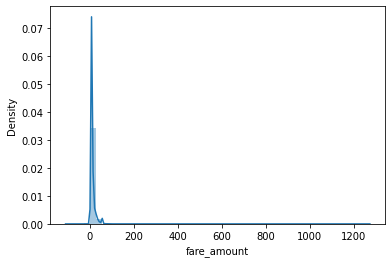

In [12]:
sns.distplot(df1['fare_amount'], kde=True)

In [8]:
df1['distance'] = sqrt((df1['dropoff_longitude']-df1['pickup_longitude'])**2+(df1['dropoff_latitude']-df1['pickup_latitude'])**2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


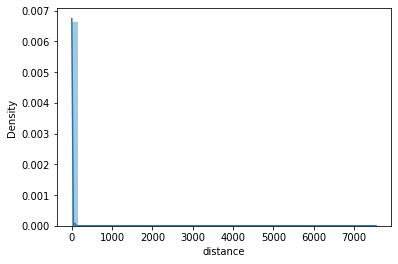

In [14]:
sns.distplot(df1['distance'], kde=True)

In [15]:
len(df1)

10000000

In [9]:
df1 = df1.dropna(subset=['distance'])

In [19]:
len(df1)

9999931

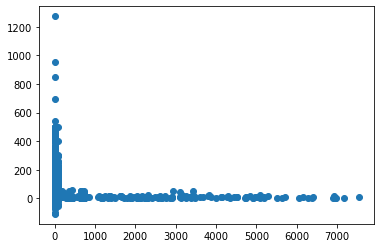

In [20]:
plt.scatter(df1['distance'],df1['fare_amount'])

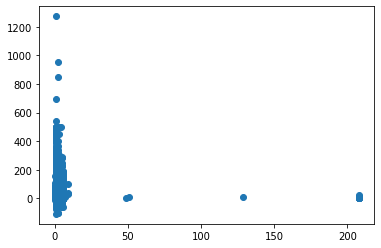

In [21]:
plt.scatter(df1['passenger_count'],df1['fare_amount'])

In [22]:
df1[df1['passenger_count']>200]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
929022,2009-07-30 11:54:00.000000193,3.3,2009-07-30 11:54:00 UTC,0.000000,0.000000,0.000000,0.000000,208,0.000000
2154045,2010-12-16 11:21:00.000000209,3.3,2010-12-16 11:21:00 UTC,0.000000,0.000000,0.000000,0.000000,208,0.000000
2198549,2010-12-15 14:20:00.00000010,3.3,2010-12-15 14:20:00 UTC,0.000000,0.000000,0.000000,0.000000,208,0.000000
2910347,2010-12-16 06:44:00.00000039,4.5,2010-12-16 06:44:00 UTC,0.000000,0.000000,0.000000,0.000000,208,0.000000
3107489,2009-05-12 14:50:00.000000175,2.7,2009-05-12 14:50:00 UTC,-73.937818,40.758260,-73.937827,40.758250,208,0.000013
4103745,2010-12-22 12:11:00.000000230,23.7,2010-12-22 12:11:00 UTC,0.000000,0.000000,0.000000,0.000000,208,0.000000
4432483,2009-05-11 13:56:00.00000088,11.1,2009-05-11 13:56:00 UTC,-73.937733,40.758267,-73.937737,40.758273,208,0.000007
7001143,2009-02-26 08:29:00.000000201,2.7,2009-02-26 08:29:00 UTC,-73.937872,40.758333,-73.937835,40.758368,208,0.000051
9310100,2012-03-08 10:44:00.00000031,3.3,2012-03-08 10:44:00 UTC,0.000000,0.000000,0.000000,0.000000,208,0.000000


In [10]:
df1 = df1[df1['passenger_count']<40]
len(df1)

9999919

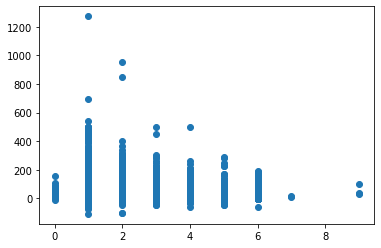

In [48]:
plt.scatter(df1['passenger_count'],df1['fare_amount'])

In [49]:
df1.describe()

,index,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,9.999919e+06,9.999919e+06,9.999919e+06,9.999919e+06,9.999919e+06,9.999919e+06,9.999919e+06,9.999919e+06
mean,5.000000e+06,1.133849e+01,-7.250784e+01,3.991939e+01,-7.250882e+01,3.991916e+01,1.684597e+00,2.564290e-01
std,2.886750e+06,9.799848e+00,1.299398e+01,9.322457e+00,1.285969e+01,9.237224e+00,1.308070e+00,1.397328e+01
min,0.000000e+00,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00,0.000000e+00
25%,2.500002e+06,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00,1.239078e-02
50%,5.000004e+06,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00,2.142930e-02
75%,7.499996e+06,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00,3.833459e-02
max,9.999999e+06,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,9.000000e+00,7.548848e+03


In [11]:
df1 = df1.reset_index()

In [12]:
df1.isnull().any()

index                False
key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
distance             False
dtype: bool

In [13]:
y = df1['fare_amount']
x = df1[['distance','passenger_count']]

In [14]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((7999935, 2), (1999984, 2), (7999935,), (1999984,))

In [15]:
scaler = StandardScaler()
scaler.fit(Xtrain)

Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [55]:
lr = LinearRegression()
lr.fit(Xtrain, ytrain)

pred_test = lr.predict(Xtest)
pred_train = lr.predict(Xtrain)

In [56]:
mean_squared_error(pred_train,ytrain), mean_squared_error(pred_test,ytest)

(95.79329484147925, 96.90525703077284)

In [57]:
r2_score(pred_train,ytrain), r2_score(pred_test,ytest)

(-4371.797973303573, -4118.5100449349975)

In [58]:
cross_val_score(LinearRegression(), x, y, scoring = 'r2', cv=3).mean()

0.00022050980604049197

In [59]:
pipeline = Pipeline([('scaling', StandardScaler()),\
                     ('features', PolynomialFeatures(degree=2)),\
                      ('regr',LinearRegression())])
cross_val_score(pipeline, x, y, cv = 3).mean()

0.0006352137448381404

In [70]:
-cross_val_score(DecisionTreeRegressor(random_state = 241),x,y, cv=3, scoring = 'neg_mean_squared_error').mean()

35.24052283089608

In [71]:
params={'max_features': [None, 'log2', 'sqrt'], 
        'max_depth': [2, 4, 6, 8, 10, 20, 50]},

gs = GridSearchCV(DecisionTreeRegressor(random_state = 241), params, cv=3, n_jobs=-1)

gs.fit(x, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=241,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=({'max_depth': [2, 4, 6, 8, 10, 20, 50],
                          'max_features': [None, 'log2', 'sqrt']},),
             pre_dispatc

In [72]:
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

0.638 (+/-0.005) for {'max_depth': 2, 'max_features': None}
0.494 (+/-0.003) for {'max_depth': 2, 'max_features': 'log2'}
0.494 (+/-0.003) for {'max_depth': 2, 'max_features': 'sqrt'}
0.716 (+/-0.003) for {'max_depth': 4, 'max_features': None}
0.681 (+/-0.009) for {'max_depth': 4, 'max_features': 'log2'}
0.681 (+/-0.009) for {'max_depth': 4, 'max_features': 'sqrt'}
0.728 (+/-0.003) for {'max_depth': 6, 'max_features': None}
0.704 (+/-0.010) for {'max_depth': 6, 'max_features': 'log2'}
0.704 (+/-0.010) for {'max_depth': 6, 'max_features': 'sqrt'}
0.730 (+/-0.003) for {'max_depth': 8, 'max_features': None}
0.729 (+/-0.007) for {'max_depth': 8, 'max_features': 'log2'}
0.729 (+/-0.007) for {'max_depth': 8, 'max_features': 'sqrt'}
0.734 (+/-0.005) for {'max_depth': 10, 'max_features': None}
0.733 (+/-0.006) for {'max_depth': 10, 'max_features': 'log2'}
0.733 (+/-0.006) for {'max_depth': 10, 'max_features': 'sqrt'}
0.711 (+/-0.005) for {'max_depth': 20, 'max_features': None}
0.711 (+/-0.005)

In [ ]:
# r2 best: 0.734 (+/-0.005) for {'max_depth': 10, 'max_features': None}

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()

cross_val_score(model_rf, x, y, cv=3, scoring='r2').mean()

In [ ]:
for n in [10, 100, 500, 1000, 10000]:
    print('n_estimators:', n)
    
    model_rf = RandomForestRegressor(n_estimators = n)

    score = cross_val_score(model_rf, x, y, cv=3, scoring='r2').mean()

    print('r2:', score)

In [16]:
 model_rf = RandomForestRegressor(n_estimators = 10)
 score = cross_val_score(model_rf, x, y, cv=3, scoring='r2').mean()

In [17]:
score

0.6838149014538798

In [ ]:
 model_rf = RandomForestRegressor(n_estimators = 100)
 score = cross_val_score(model_rf, x, y, cv=3, scoring='r2').mean()
 print(score)

In [20]:
model_gb = GradientBoostingClassifier(n_estimators = 10)

score = cross_val_score(model_gb, x,y, cv=3, scoring = 'r2').mean()

print(score)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)


nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)


In [21]:
import xgboost as xgb

xgb.__version__

'0.90'

In [23]:
rng = np.random.RandomState(31337)

kf = KFold(n_splits=2, shuffle=True, random_state=rng)

In [25]:
for fold_index, (train_index, test_index) in enumerate(kf.split(x)):
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(x[train_index], y[train_index])
    predictions = xgb_model.predict(x[test_index])
    actuals = y[test_index]
    print("RMSE on fold {}: {}".format(fold_index, np.sqrt(mean_squared_error(actuals, predictions))))

KeyError: ignored

In [26]:
def get_params():
    params = {}
    params["objective"] = "reg:linear"
    params["booster"] = "gbtree"
    params["eval_metric"] = "rmse"
    params["num_boost_round"] = 100
    params["max_depth"] = 3
    params["tree_method"] = "approx"
    params["sketch_eps"] = 1
    
    return params
    
for fold_index, (train_index, test_index) in enumerate(kf.split(x)):

    params = get_params()
    
    xgtrain = xgb.DMatrix(x[train_index], label=y[train_index])
    xgtest = xgb.DMatrix(x[test_index], label=y[test_index])
    
    bst = xgb.train(params, xgtrain) #аналог fit в sklearn

    print("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))

KeyError: ignored